<center>
<div style="max-width:400px;">

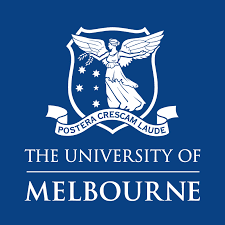

</div>
</center>

# Fitted Line Polynomial Regression

**Prof. Kevin Otto and Nikolas Crossan**  
The University of Melbourne  
Department of Mechanical Engineering

----------------------------------------------------------------------------

This notebook demonstrates ordinary least squares regression of one variable.  
1. Linear regression
2. Quadratic regression
3. Cubic regression

This notebook relies on the `mqrpy` code library, found at https://pypi.org/project/mqrpy/


In [1]:
import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack, grab_figure, Line

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import summary_table

from importlib.metadata import version
print('MQR version', version('mqrpy'))
print('Numpy version', version('numpy'))
print('Scipy version', version('scipy'))
print('Pandas version', version('pandas'))

MQR version 0.6.0
Numpy version 1.26.4
Scipy version 1.13.1
Pandas version 2.2.2


--------------------------------------------------------------------------------------------------
# 1. Simple Linear Regression

First define a Pandas dataframe with the data to fit.  Here pressure drop and airflow.

In [2]:
data = {'ESP':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'SCFM':[2165.0, 2071.0, 2047.1, 1961.1, 1903.7,
                1835.3, 1750.9, 1655.6, 1599.7, 1507.0]}
df = pd.DataFrame(data)
df

,ESP,SCFM
0,0.1,2165.0
1,0.2,2071.0
2,0.3,2047.1
3,0.4,1961.1
4,0.5,1903.7
5,0.6,1835.3
6,0.7,1750.9
7,0.8,1655.6
8,0.9,1599.7
9,1.0,1507.0


Now do a simple Linear Regression using ols from Statsmodels.  

Do a linear fit of SCFM vs ESP.  The syntax is `'SCFM ~ ESP'` to signify there is 1 term in the model, ESP.  

StatsModels saves the result as a Pandas dataframe.  

Also save slope and intercept.

In [3]:
lfit = df.copy()

lreg = ols('SCFM ~ ESP', data=lfit).fit()
intercept = lreg.params['Intercept']
slope = lreg.params['ESP']

Create a simple linear trendline graph and print the equation as a legend, using seaborn.

,S,R-sq,R-sq (adj),F,PR(>F),AIC,BIC,N
,18.57,0.9936,0.9928,1239.09,0.000,88.58,89.19,10

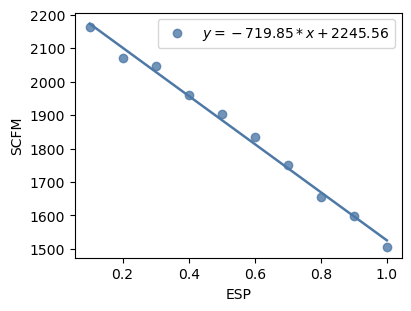

In [4]:
with Figure(4, 3) as (fig, ax):
    sns.regplot(x='ESP', y='SCFM', data=df, ci=0, ax=ax)
    ax.legend([f'$y = {slope:.2f} * x + {intercept:.2f}$'])
    plot = grab_figure(fig)

vstack(
    mqr.anova.adequacy(lreg),
    plot)

The Summary Statistics Table shows a residual error of $\pm$18.6 SCFM, with an $r^2_{adj}$ of 0.993.  That is good.  The regression has a F-stat of 1239, very large and far from zero, and an associated p-value of 0.000, indicating we can reject the null hypothesis that the result is no different from random variability (the regression equation is zero).  

Now create the full regression tables.

In [5]:
vstack(
   '### Summary Statistics',
    mqr.anova.adequacy(lreg),
   '### ANOVA of the Regression',
    mqr.anova.summary(lreg),
   '### Regression Table',
    mqr.anova.coeffs(lreg)
)

The ANOVA of the Regression again shows the F-stat and p-value of the regression, and indicates the model is significant.  

The Regression Table then shows the model equation coefficients, their t-stat and p-value of each term.  Both p-values are low, and so we can reject the null hypothesis that the coefficient is zero. Each coefficient is significant.  The VIF values are under 10 and so collinearity is not a problem.

## 1.2 Residual Analysis

Create the 4 in 1 plot of the residuals using `mqr.plot.regression.residuals`

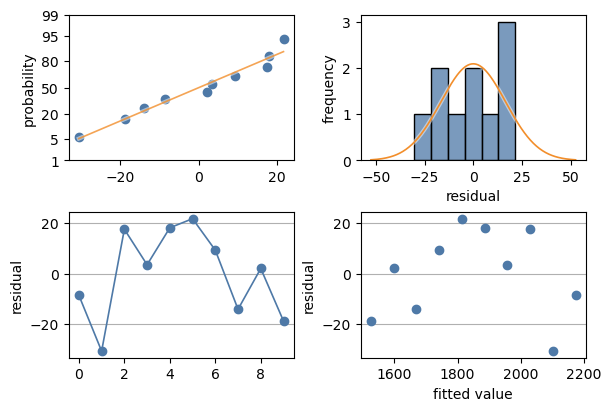

In [6]:
with Figure(6, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(lreg.resid, lreg.fittedvalues, ax)

Do the residuals look independent, identically normally distributed?  

The upper left plot doesn't show any large offsets from the fit line.  The upper right has few data points so it is hard to say the histogram is not normal.  The lower left shows the residual vs run order, but the runs were not randomized so this can be ignored. The lower right shows the residuals vs fitted value, and that graph looks suspicious, a quadratic look to it.  

-------------------------------------------------------------------------------------------------------

## 1.3 Summary Fitted Line Plot

Now create a fitted line plot with confidence intervals for the line, and prediction intervals for values. 

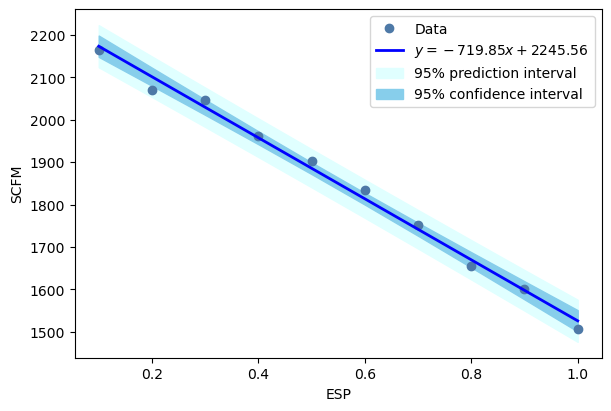

In [7]:
from statsmodels.stats.outliers_influence import summary_table

st, data, ss2 = summary_table(lreg, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

x = df['ESP']
y = df['SCFM']

with Figure(6, 4) as (fig, ax):
    ax.plot(x, y, 'o')
    ax.plot(x, fittedvalues, 'b-', lw=2)
    ax.fill_between(x, predict_ci_upp, predict_ci_low, color = 'lightcyan')
    ax.fill_between(x, predict_mean_ci_upp, predict_mean_ci_low, color = 'skyblue')

    ax.set_xlabel("ESP")
    ax.set_ylabel("SCFM")
    ax.legend([
        'Data',
        f'$y = {slope:.2f}x + {intercept:.2f}$',
        '95% prediction interval',
        '95% confidence interval'
    ])

We expect the true regression line to be within the confidence interval, we expect all data to be within the prediction interval. 

---------------------------------------------------------------------------

## 2. Quadratic Polynominal Regression

Now redo the previous example but instead fit a quadratic model.

First define a Pandas dataframe with the data to fit.  Here pressure drop, pressure drop squared and airflow.

In [8]:
qfit = df[['ESP', 'SCFM']].copy()
qfit['ESP2'] = df['ESP']*df['ESP']
qfit = qfit[['ESP', 'ESP2', 'SCFM']]
qfit

,ESP,ESP2,SCFM
0,0.1,0.01,2165.0
1,0.2,0.04,2071.0
2,0.3,0.09,2047.1
3,0.4,0.16,1961.1
4,0.5,0.25,1903.7
5,0.6,0.36,1835.3
6,0.7,0.49,1750.9
7,0.8,0.64,1655.6
8,0.9,0.81,1599.7
9,1.0,1.00,1507.0


Now do a quadratic polynomial regression using ols from Statsmodels.  

Do a fit of SCFM vs EPS as a quadratic equation.    

,S,R-sq,R-sq (adj),F,PR(>F),AIC,BIC,N
,14.22,0.9967,0.9958,1060.39,0.000,83.91,84.81,10

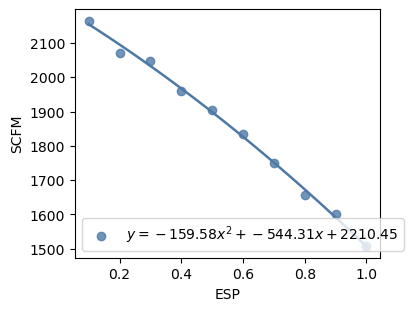

In [9]:
qreg = ols('SCFM ~ ESP + ESP2', data=qfit).fit()
intercept, slope, quadratic = qreg.params

with Figure(4, 3) as (fig, ax):
    sns.regplot(x='ESP', y='SCFM', data=df, ci=0, order=2, ax=ax)
    ax.legend([f'$y={quadratic:.2f}x^2 + {slope:.2f}x + {intercept:.2f}$'])
    plot = grab_figure(fig)

vstack(
    mqr.anova.adequacy(qreg),
    plot)

Now do the whole thing of the regression tables, residual analysis and the 4 in 1 plots


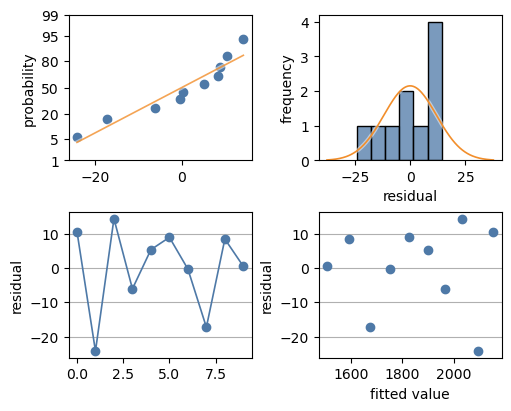

In [10]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(qreg.resid, qreg.fittedvalues, axs=ax)
    plot = grab_figure(fig)

vstack(
    Line.HORIZONTAL,
    '### Regression Summary',
    vstack(
        '#### Summary Statistics',
        mqr.anova.adequacy(qreg),
        '#### ANOVA of the Regression',
        mqr.anova.summary(qreg),
       '#### Regression Table',
        mqr.anova.coeffs(qreg),
    ),
    Line.HORIZONTAL,
    '### Residual Analysis',
    hstack(
        plot,
        mqr.inference.dist.test_1sample(qreg.resid),
    ),
)

Considering the outcomes, similar to the linear fit. The Summary Statistics Table shows a residual error of $\pm$14.2 SCFM, with an $r^2_{adj}$ of 0.996.  That is good.  The regression has a F-stat of 1060, very large and far from zero, and an associated p-value of 0.000, indicating we can reject the null hypothesis that the result is no different from random variability (the regression equation is zero). 

The ANOVA of the Regression again shows the F-stat and p-value of the regression, and indicates the model is significant.  

The Regression Table then shows the model equation coefficients, their t-stat and p-value of each term.  Both p-values are low, and so we can reject the null hypothesis that the coefficient is zero. Each coefficient is significant.  The VIF values are not under 10 and so collinearity is becoming a concern, the ESP and ESP^2 are starting to look alike. Normalizing the variable ESP would help this.  

### Summary Fitted Line Plot

Now create a fitted line plot with confidence intervals for the line and prediction intervals for values.  

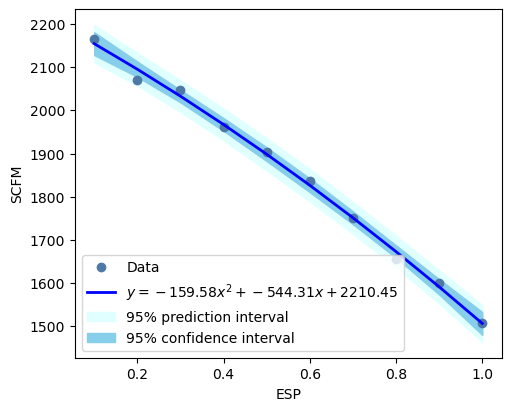

In [11]:
st, data, ss2 = summary_table(qreg, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

x = df['ESP']
y = df['SCFM']

with Figure(5, 4) as (fig, ax):
    ax.plot(x, y, 'o')
    ax.plot(x, fittedvalues, 'b-', lw=2)
    ax.fill_between(x, predict_ci_upp, predict_ci_low, color = 'lightcyan')
    ax.fill_between(x, predict_mean_ci_upp, predict_mean_ci_low, color = 'skyblue')

    ax.set_ylabel("SCFM")
    ax.set_xlabel("ESP")
    ax.legend([
        'Data',
        f'$y={quadratic:.2f}x^2 + {slope:.2f}x + {intercept:.2f}$',
        '95% prediction interval',
        '95% confidence interval',
    ])

---------------------------------------------------------------------------
## 3. Cubic Polynominal Regression

Now redo the previous example but instead fit a cubic equation.

First define a Pandas dataframe with the data to fit.  Here pressure drop through cubed, and airflow.

In [12]:
cfit = df[['ESP', 'SCFM']].copy()
cfit['ESP2'] = df['ESP']*df['ESP']
cfit['ESP3'] = df['ESP']*df['ESP']*df['ESP']
cfit = cfit[['ESP', 'ESP2', 'ESP3', 'SCFM']]
cfit

,ESP,ESP2,ESP3,SCFM
0,0.1,0.01,0.001,2165.0
1,0.2,0.04,0.008,2071.0
2,0.3,0.09,0.027,2047.1
3,0.4,0.16,0.064,1961.1
4,0.5,0.25,0.125,1903.7
5,0.6,0.36,0.216,1835.3
6,0.7,0.49,0.343,1750.9
7,0.8,0.64,0.512,1655.6
8,0.9,0.81,0.729,1599.7
9,1.0,1.00,1.000,1507.0


/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


,S,R-sq,R-sq (adj),F,PR(>F),AIC,BIC,N
,15.36,0.9967,0.9951,605.94,0.000,85.91,87.12,10

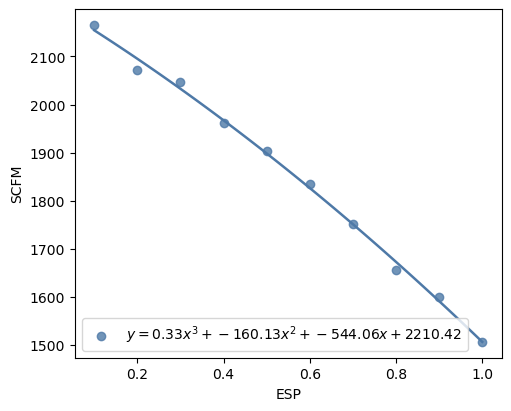

In [13]:
creg = ols('SCFM ~ ESP + ESP2 + ESP3', data=cfit).fit()
intercept, slope, quadratic, cubic = creg.params

with Figure(5, 4) as (fig, ax):
    sns.regplot(x='ESP', y='SCFM', data=df, ci=0, order=3, ax=ax)
    ax.legend([f'$y = {cubic:.2f}x^3 + {quadratic:.2f}x^2 + {slope:.2f}x + {intercept:.2f}$'])
    plot = grab_figure(fig)

vstack(
     mqr.anova.adequacy(creg),
     plot)


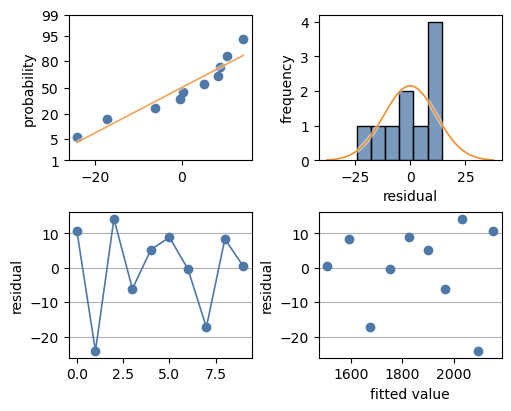

In [14]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(creg.resid, creg.fittedvalues, axs=ax)
    plot = grab_figure(fig)

vstack(
    Line.HORIZONTAL,
    '### Regression Summary',
    vstack(
        '#### Summary Statistics',
        mqr.anova.adequacy(creg),
        '#### ANOVA of the Regression',
        mqr.anova.summary(creg),
        '#### Regression Table',
       mqr.anova.coeffs(creg)
    ),
    Line.HORIZONTAL,
    '### Residual Analysis',
    hstack(
        plot,
        mqr.inference.dist.test_1sample(creg.resid),
    )
)

Considering the outcomes, similar to the previous fits. The Summary Statistics Table shows a residual error of $\pm$15.3 SCFM, with an $r^2_{adj}$ of 0.995.  That is good.  The regression has a F-stat of 606, very large and far from zero, and an associated p-value of 0.000, indicating we can reject the null hypothesis that the result is no different from random variability (the regression equation is zero). 

The ANOVA of the Regression again shows the F-stat and p-value of the regression, and indicates the model is significant.  

The Regression Table then shows the model equation coefficients, their t-stat and p-value of each term.  Now the p-values are not all low, the ESP^2 and ESP^3 terms are insignificant. The VIF values are also not under 10 and so collinearity is a concern.  


### Summary Fitted Line Plot

Now create a fitted line plot with confidence intervals for the line and prediction intervals for values.  

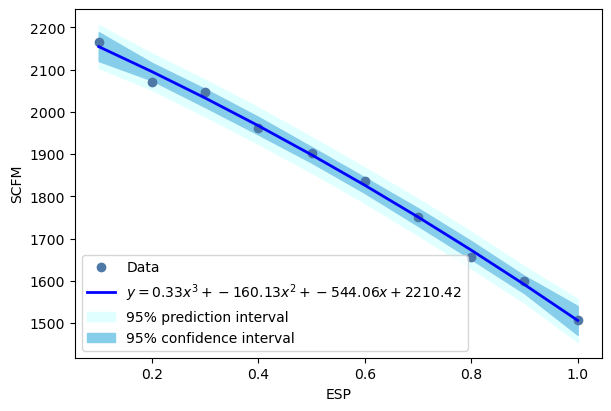

In [15]:
st, data, ss2 = summary_table(creg, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

x = df['ESP']
y = df['SCFM']

with Figure(6, 4) as (fig, ax):
    ax.plot(x, y, 'o')
    ax.plot(x, fittedvalues, 'b-', lw=2)
    ax.fill_between(x, predict_ci_upp, predict_ci_low, color = 'lightcyan')
    ax.fill_between(x, predict_mean_ci_upp, predict_mean_ci_low, color = 'skyblue')
    
    ax.set_xlabel("ESP")
    ax.set_ylabel("SCFM")
    ax.legend([
        'Data',
        f'$y = {cubic:.2f}x^3 + {quadratic:.2f}x^2 + {slope:.2f}x + {intercept:.2f}$',
        '95% prediction interval',
        '95% confidence interval'
    ])

# 4.0 Comparison of Models

We can compare the linear, quadratic and cubic models on their adjusted r2 and the standard error of the residuals.  Notice the cubic model is not the best.  

In [16]:
vstack(
    '#### Linear Regression',
    mqr.anova.adequacy(lreg),
    '#### Quadratic Regression',
    mqr.anova.adequacy(qreg),
    '#### Cubic Regression',
    mqr.anova.adequacy(creg),
)

,S,R-sq,R-sq (adj),F,PR(>F),AIC,BIC,N
,18.57,0.9936,0.9928,1239.09,0.000,88.58,89.19,10
,S,R-sq,R-sq (adj),F,PR(>F),AIC,BIC,N
,14.22,0.9967,0.9958,1060.39,0.000,83.91,84.81,10
,S,R-sq,R-sq (adj),F,PR(>F),AIC,BIC,N
,15.36,0.9967,0.9951,605.94,0.000,85.91,87.12,10


As can be seen, the quadratic model has smallest residual error, and largest rsquared-adjusted, and is the most parsimonious model.  Even with more terms, the cubic model has larger residual error (fit worse).  Notice $r^2$ always got better with more terms, it is misleading. The $r^2_{adj}$ got worse with the cubic model.  